In [3]:
import kagglehub


path = kagglehub.dataset_download("ashutosh598/shoes-price-for-various-brands")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\tahas\.cache\kagglehub\datasets\ashutosh598\shoes-price-for-various-brands\versions\1


In [66]:
import pandas as pd


csv_path = r"C:\Users\tahas\.cache\kagglehub\datasets\ashutosh598\shoes-price-for-various-brands\versions\1\data.csv"


data = pd.read_csv(csv_path)


data.head()


,brand,color,size,price,offer_price
0,Tresmode,Black,6.5,4647,4153
1,Lavie,Gold,4,2446,1172
2,FILA,Red,6,2346,1898
3,Crocs,Red,5,5942,5868
4,Crocs,Blue,4,2942,2118


In [67]:

data.info()

data.describe()

data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5679 entries, 0 to 5678
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   brand        5679 non-null   object
 1   color        5679 non-null   object
 2   size         5679 non-null   object
 3   price        5679 non-null   int64 
 4   offer_price  5679 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 222.0+ KB


brand          0
color          0
size           0
price          0
offer_price    0
dtype: int64

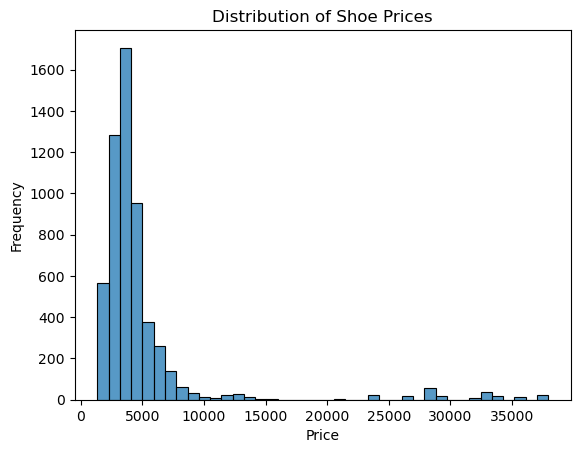

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.histplot(data['price'], bins=40, kde=False)
plt.title('Distribution of Shoe Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


In [69]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer


TARGET = "price"
cat_cols = ["brand", "color", "size"]
num_cols = [c for c in data.columns if c not in cat_cols + [TARGET]]  


X = data.drop(columns=[TARGET]).copy()
y = data[TARGET].astype(float).values  


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42
)


preprocess = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols),
        ("num", MinMaxScaler(), num_cols),
    ],
    remainder="drop",  
)

X_train_proc = preprocess.fit_transform(X_train)
X_val_proc   = preprocess.transform(X_val)
X_test_proc  = preprocess.transform(X_test)


print("Raw feature preview (pre-preprocessing):")
print(X.head(), "\n")

print("Shapes (after preprocessing):")
print("X_train:", X_train_proc.shape, " y_train:", y_train.shape)
print("X_val:  ", X_val_proc.shape,   " y_val:  ", y_val.shape)
print("X_test: ", X_test_proc.shape,  " y_test: ", y_test.shape)



Raw feature preview (pre-preprocessing):
      brand  color size  offer_price
0  Tresmode  Black  6.5         4153
1     Lavie   Gold    4         1172
2      FILA    Red    6         1898
3     Crocs    Red    5         5868
4     Crocs   Blue    4         2118 

Shapes (after preprocessing):
X_train: (3634, 4)  y_train: (3634,)
X_val:   (909, 4)  y_val:   (909,)
X_test:  (1136, 4)  y_test:  (1136,)


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense





def create_mlp():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
   

    model.add(Dense(32, activation='relu'))


    model.add(Dense(16, activation='relu'))


    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model



mlp_model = create_mlp()

mlp_model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae', 'mse', r_squared])

# no need to retrain just to evaluate with a new metric


mlp_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 64)                320       
                                                                 
 dense_29 (Dense)            (None, 32)                2080      
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,945
Trainable params: 2,945
Non-trainable params: 0
_________________________________________________________________


In [72]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()

data['brand'] = label_encoder.fit_transform(data['brand'])
data['color'] = label_encoder.fit_transform(data['color'])
data['size'] = label_encoder.fit_transform(data['size'])
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())






def to_float32(a):
    a = pd.DataFrame(a).apply(pd.to_numeric, errors="coerce").to_numpy(dtype=np.float32)
    return np.nan_to_num(a, nan=0.0, posinf=1e9, neginf=-1e9)

X_train_np = to_float32(X_train)
X_val_np   = to_float32(X_val)
X_test_np  = to_float32(X_test)

y_train_np = np.asarray(y_train, dtype=np.float32)
y_val_np   = np.asarray(y_val,   dtype=np.float32)
y_test_np  = np.asarray(y_test,  dtype=np.float32)

cbs = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1),
]


history = mlp_model.fit(
    X_train_np, y_train_np,
    validation_data=(X_val_np, y_val_np),
    epochs=500,
    batch_size=64,
    callbacks=cbs,
    verbose=1
)


test_loss, test_mae, test_mse, test_r2 = mlp_model.evaluate(X_test_np, y_test_np, verbose=0)
print(f"[TEST] Loss={test_loss:.6f}  MAE={test_mae:.6f}  MSE={test_mse:.6f}  R^2={test_r2:.6f}")


results = mlp_model.evaluate(X_test_np, y_test_np, verbose=0, return_dict=True)
print(results)  

print(
    f"[TEST] Loss={results['loss']:.6f}  "
    f"MAE={results.get('mae', float('nan')):.6f}  "
    f"MSE={results.get('mse', float('nan')):.6f}  "
    f"R^2={results.get('r_squared', float('nan')):.6f}"
)


Epoch 1/500
57/57 [==============================] - 1s 8ms/step - loss: 53672060.0000 - mae: 5001.5288 - mse: 53672060.0000 - r_squared: -1.4284 - val_loss: 63000424.0000 - val_mae: 5244.7725 - val_mse: 63000424.0000 - val_r_squared: -1.6521
Epoch 2/500
57/57 [==============================] - 0s 3ms/step - loss: 45913404.0000 - mae: 4649.2002 - mse: 45913404.0000 - r_squared: -1.3648 - val_loss: 54182232.0000 - val_mae: 4881.1489 - val_mse: 54182232.0000 - val_r_squared: -1.2900
Epoch 3/500
57/57 [==============================] - 0s 3ms/step - loss: 39924500.0000 - mae: 4345.0625 - mse: 39924500.0000 - r_squared: -0.9793 - val_loss: 47280420.0000 - val_mae: 4575.0625 - val_mse: 47280420.0000 - val_r_squared: -1.0065
Epoch 4/500
57/57 [==============================] - 0s 4ms/step - loss: 35174848.0000 - mae: 4096.7373 - mse: 35174848.0000 - r_squared: -0.7301 - val_loss: 41584800.0000 - val_mae: 4304.9727 - val_mse: 41584800.0000 - val_r_squared: -0.7725
Epoch 5/500
57/57 [=========

71/71 [==============================] - 0s 3ms/step - loss: 5.6082e-04 - mae: 0.0177 - mse: 5.6082e-04 - r_squared: 0.9595 - val_loss: 5.1260e-04 - val_mae: 0.0174 - val_mse: 5.1260e-04 - val_r_squared: 0.9425
Epoch 409/500
71/71 [==============================] - 0s 3ms/step - loss: 5.2710e-04 - mae: 0.0171 - mse: 5.2710e-04 - r_squared: 0.9511 - val_loss: 5.0651e-04 - val_mae: 0.0164 - val_mse: 5.0651e-04 - val_r_squared: 0.9448
Epoch 410/500
71/71 [==============================] - 0s 3ms/step - loss: 5.4205e-04 - mae: 0.0173 - mse: 5.4205e-04 - r_squared: 0.9553 - val_loss: 6.5675e-04 - val_mae: 0.0204 - val_mse: 6.5675e-04 - val_r_squared: 0.9212
Epoch 411/500
71/71 [==============================] - 0s 3ms/step - loss: 6.2116e-04 - mae: 0.0186 - mse: 6.2116e-04 - r_squared: 0.9531 - val_loss: 6.4395e-04 - val_mae: 0.0203 - val_mse: 6.4395e-04 - val_r_squared: 0.9223
Epoch 412/500
71/71 [==============================] - 0s 3ms/step - loss: 5.7064e-04 - mae: 0.0178 - mse: 5.7064e

71/71 [==============================] - 0s 3ms/step - loss: 6.7799e-04 - mae: 0.0195 - mse: 6.7799e-04 - r_squared: 0.9419 - val_loss: 5.0262e-04 - val_mae: 0.0164 - val_mse: 5.0262e-04 - val_r_squared: 0.9404
Epoch 445/500
71/71 [==============================] - 0s 3ms/step - loss: 5.5510e-04 - mae: 0.0177 - mse: 5.5510e-04 - r_squared: 0.9479 - val_loss: 9.2020e-04 - val_mae: 0.0227 - val_mse: 9.2020e-04 - val_r_squared: 0.8950
Epoch 446/500
71/71 [==============================] - 0s 3ms/step - loss: 5.9315e-04 - mae: 0.0181 - mse: 5.9315e-04 - r_squared: 0.9426 - val_loss: 7.0927e-04 - val_mae: 0.0191 - val_mse: 7.0927e-04 - val_r_squared: 0.9164
Epoch 447/500
71/71 [==============================] - 0s 3ms/step - loss: 5.2776e-04 - mae: 0.0172 - mse: 5.2776e-04 - r_squared: 0.9607 - val_loss: 5.6478e-04 - val_mae: 0.0171 - val_mse: 5.6478e-04 - val_r_squared: 0.9353
Epoch 448/500
71/71 [==============================] - 0s 3ms/step - loss: 5.7884e-04 - mae: 0.0177 - mse: 5.7884e

71/71 [==============================] - 0s 3ms/step - loss: 5.2672e-04 - mae: 0.0172 - mse: 5.2672e-04 - r_squared: 0.9532 - val_loss: 5.0080e-04 - val_mae: 0.0172 - val_mse: 5.0080e-04 - val_r_squared: 0.9401
Epoch 481/500
71/71 [==============================] - 0s 3ms/step - loss: 5.3838e-04 - mae: 0.0173 - mse: 5.3838e-04 - r_squared: 0.9577 - val_loss: 7.7459e-04 - val_mae: 0.0201 - val_mse: 7.7459e-04 - val_r_squared: 0.9093
Epoch 482/500
71/71 [==============================] - 0s 3ms/step - loss: 6.1550e-04 - mae: 0.0185 - mse: 6.1550e-04 - r_squared: 0.9472 - val_loss: 9.2670e-04 - val_mae: 0.0227 - val_mse: 9.2670e-04 - val_r_squared: 0.8888
Epoch 483/500
71/71 [==============================] - 0s 3ms/step - loss: 6.0052e-04 - mae: 0.0184 - mse: 6.0052e-04 - r_squared: 0.9377 - val_loss: 5.0123e-04 - val_mae: 0.0164 - val_mse: 5.0123e-04 - val_r_squared: 0.9399
Epoch 484/500
71/71 [==============================] - 0s 3ms/step - loss: 5.6631e-04 - mae: 0.0178 - mse: 5.6631e

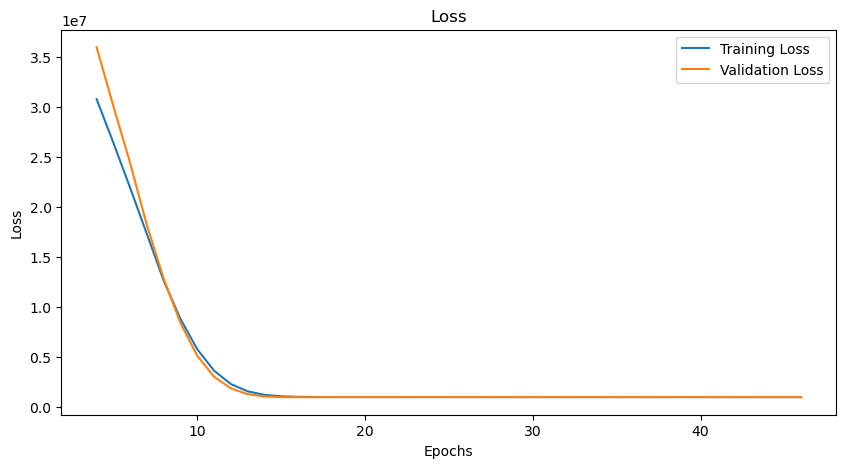

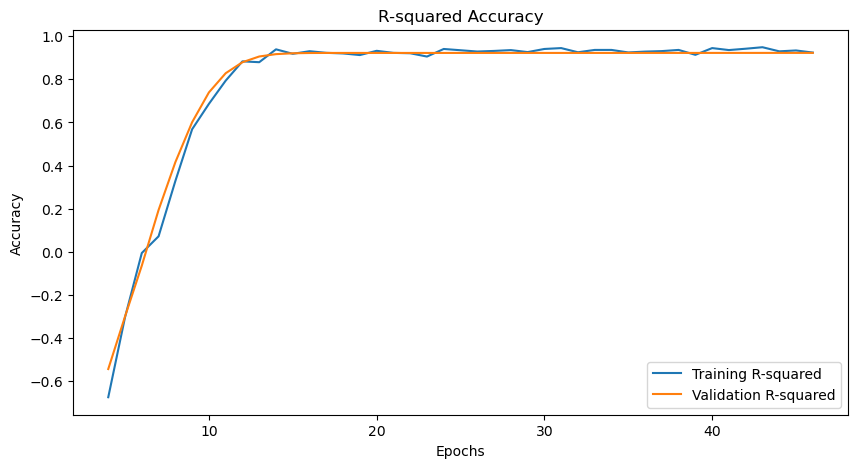

In [75]:
import matplotlib.pyplot as plt


ignore_epochs = 4


epochs = range(ignore_epochs, len(history.history['loss']))
training_loss = history.history['loss'][ignore_epochs:]
validation_loss = history.history['val_loss'][ignore_epochs:]
training_r2 = history.history['r_squared'][ignore_epochs:]
validation_r2 = history.history['val_r_squared'][ignore_epochs:]


plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(epochs, training_r2, label='Training R-squared')
plt.plot(epochs, validation_r2, label='Validation R-squared')
plt.title('R-squared Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


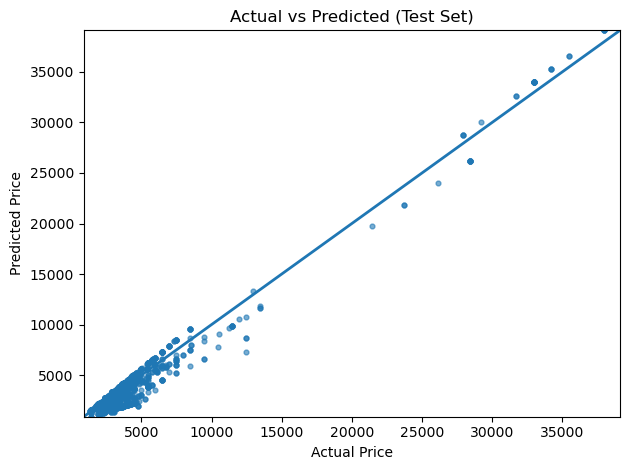

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use your processed arrays
y_true = y_test_np.ravel()
y_pred = mlp_model.predict(X_test_np, verbose=0).ravel()

# Scatter + 1:1 reference line
plt.figure()
plt.scatter(y_true, y_pred, s=12, alpha=0.6)
vmin = float(min(y_true.min(), y_pred.min()))
vmax = float(max(y_true.max(), y_pred.max()))
plt.plot([vmin, vmax], [vmin, vmax], linewidth=2)  # ideal line
plt.xlim(vmin, vmax); plt.ylim(vmin, vmax)
plt.xlabel('Actual Price'); plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()


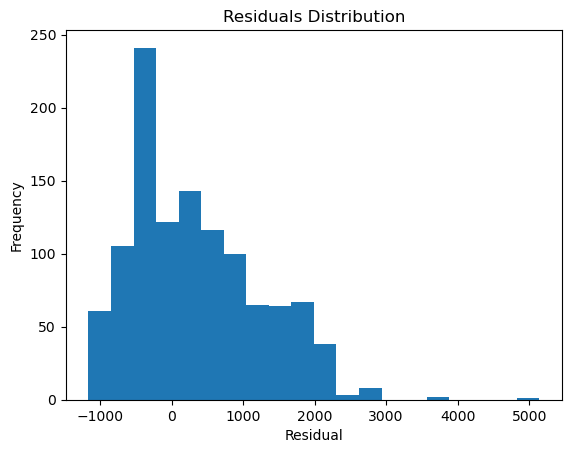

In [79]:
residuals = y_test - y_pred.flatten()
plt.hist(residuals, bins=20)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()
